# DataLoader in PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/HSE_DL_2021/04_week

/content/gdrive/My Drive/HSE_DL_2021/04_week


__DataLoader__ -- класс в PyTorch, который позволяет итеративно проходить по датасету, отвечает за оркестрацию всего процесса работы с датасетом.

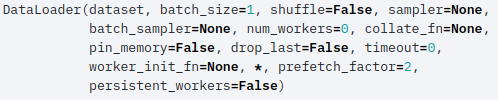

In [2]:
from IPython import display
display.Image('images/DataLoaderParams.png')

- __dataset__ -- позволяет создать кастомные классы для работы с датасетом, где можно указать логику формирвоания батча. 
  * как считать данные,
  * что отдать на выход
- __sampler__ -- определяет порядок элементов из датасета, которые будут идти в батч, то есть это список индексов, объединенных в батч. Удобно переопределять, когда обучение распредленное.  
  * есть готовые сэмплеры
- __collate_fn__ -- позволяет сделать финальную предобработку над батчем данных. Если, например, в батч попали последовательности разных размеров, то после уже сбора батча, можно будет дополнить последовательности нулями относительно максимально длиной последовательности.
  * позволяет подготовить данные для батча



## Custom Dataset

In [11]:
import pandas as pd
import pickle
import numpy as np

from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.dataloader import default_collate

In [12]:
BATCH_SIZE = 128
EPOCHS = 100

In [26]:
with open('data/X_train_cat.pickle', 'rb') as f:
    X, target = pickle.load(f)
X.shape

(21383, 37)

In [13]:
# пусть у нас лежат данные внутри папки по кускам
# path = spark_data_folder

class CustomDataset(Dataset):
    # Конструктор, где считаем датасет
    def __init__(self, dataset_path):
        # for part in glob(path) - это чтобы пробежаться по спарк файлам
        with open(dataset_path, 'rb') as f:
            self.X, self.target = pickle.load(f)

        return
    
    # Переопределяем метод вычисление размера датасета
    def __len__(self):
        return len(self.X)

    # Переопределяем метод,
    # который достает по индексу наблюдение из датасет
    def __getitem__(self, idx):
        return self.X[idx], self.target[idx]
        

## Custom Sampler

In [14]:
np.random.permutation([1,2,3])

array([1, 3, 2])

In [15]:
class CustomSampler(Sampler):

    # Конструктор, где инициализируем индексы элементов
    def __init__(self, data):
        self.data_indices = np.arange(len(data))

        shuffled_indices = np.random.permutation(len(self.data_indices))

        self.data_indices = np.ascontiguousarray(self.data_indices)[shuffled_indices]

        return

    def __len__(self):
        return len(self.data_indices)

    # Возращает итератор,
    # который будет возвращать индексы из перемешанного датасета
    def __iter__(self):
        return iter(self.data_indices)

## Custom Sampler

In [8]:
def collate(batch):
    return default_collate(batch) # базово превращает в тензор + что-то делает 
    # еще дополнительное

In [19]:
def create_data_loader(train_dataset, train_sampler,
                       test_dataset, test_sampler):
    train_loader = DataLoader(dataset=train_dataset, sampler=train_sampler,
                              batch_size=BATCH_SIZE, collate_fn=collate,
                              shuffle=False)
    # когда мы используем сэмплер - нужно выключать shuffle=False

    test_loader = DataLoader(dataset=test_dataset, sampler=test_sampler,
                             batch_size=BATCH_SIZE, collate_fn=collate,
                             shuffle=False)

    return train_loader, test_loader

In [20]:
# Создаем объекты Custom Dataset и Sampler
train_ds = CustomDataset('data/X_train_cat.pickle')
train_sampler = CustomSampler(train_ds.X)

test_ds = CustomDataset('data/X_test_cat.pickle')
test_sampler = CustomSampler(test_ds.X)

In [21]:
train_loader, test_loader = create_data_loader(train_ds, train_sampler,
                                               test_ds, test_sampler)

In [24]:
def run_train():
    print('Run train')
    for epoch in range(EPOCHS):
        for features, labels in train_loader:
            print(features.shape, labels)
            break

        # Run validation
        print('Run validation')
        for features, labels in test_loader:
            print(features.shape, labels)
            break
            
        break

    return

In [25]:
run_train()

Run train
torch.Size([128, 37]) tensor([3, 0, 3, 0, 3, 1, 3, 3, 2, 2, 3, 3, 0, 3, 0, 0, 0, 3, 3, 2, 1, 0, 3, 0,
        2, 3, 3, 0, 2, 0, 3, 3, 2, 3, 0, 0, 0, 0, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3,
        2, 3, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 2, 0, 1, 3, 3, 3, 0, 3, 1, 2, 0, 1,
        0, 2, 0, 2, 1, 0, 3, 3, 1, 0, 2, 0, 0, 0, 3, 0, 3, 1, 3, 0, 0, 0, 0, 3,
        3, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 2, 0, 0, 3, 0, 0, 3, 3,
        2, 1, 3, 3, 0, 3, 0, 2])
Run validation
torch.Size([128, 37]) tensor([2, 3, 3, 0, 2, 2, 2, 3, 0, 3, 2, 2, 1, 3, 3, 2, 3, 3, 0, 0, 1, 0, 2, 3,
        0, 2, 0, 1, 2, 2, 3, 0, 3, 0, 2, 0, 3, 3, 0, 3, 0, 0, 3, 3, 2, 2, 0, 0,
        0, 0, 3, 3, 0, 0, 2, 1, 3, 0, 2, 3, 3, 3, 0, 0, 3, 3, 0, 3, 2, 0, 3, 0,
        2, 2, 0, 0, 3, 2, 0, 3, 3, 3, 0, 3, 2, 2, 1, 3, 0, 0, 3, 0, 2, 2, 2, 2,
        0, 2, 3, 0, 3, 3, 3, 0, 3, 2, 0, 0, 3, 0, 0, 3, 2, 0, 3, 0, 3, 0, 0, 3,
        0, 3, 0, 3, 0, 3, 0, 0])
